In [1]:
# library(devtools)  # if not installed: install.packages('devtools')
# library(remotes)
# remotes::install_github("RubD/Giotto@cless") 
library(Giotto)

In [2]:
# path to simulated data
path_to_matrix = system.file("simulation", "rescale25_gio.txt", package = 'Giotto')
# path_to_matrix = system.file("simulation", "thrane.txt", package = 'Giotto')
path_to_locations = system.file("simulation", "locs.txt", package = 'Giotto')
# installGiottoEnvironment()
print(path_to_matrix)

[1] "/usr/local/lib/R/site-library/Giotto/simulation/thrane.txt"


In [3]:
# select_NearestNetwork was missed in this version
select_NearestNetwork = function(gobject,
                                 nn_network_to_use = 'sNN',
                                 network_name = 'sNN.pca',
                                 output = c('igraph', 'data.table')) {

  output = match.arg(arg = output, choices = c('igraph', 'data.table'))

  ## select network to use
  if(is.null(nn_network_to_use) | is.null(network_name)) {
    stop('\n you need to select network type: knn or snn \n
         and you need to select the network name you created\n')
  } else {
    print(gobject@nn_network)
    igraph_object = gobject@nn_network[[nn_network_to_use]][[network_name]][['igraph']]
    if(is.null(igraph_object)) {
      cat('\n nn_network_to_use or network_name does not exist, \n
           create a nearest-neighbor network first \n')
    }
  }

  ## convert igraph to data.table
  if(output == 'data.table') {
    igraph_object = data.table::as.data.table(igraph::get.data.frame(x = igraph_object))
    return(igraph_object)
  }

  return(igraph_object)

}

In [3]:
my_giotto_object = createGiottoObject(raw_exprs = path_to_matrix, spatial_locs = path_to_locations)

my_giotto_object@cell_metadata

Consider to install these (optional) packages to run all possible Giotto commands for spatial analyses:  MAST smfishHmrf trendsceek SPARK multinet RTriangle FactoMiner
 Giotto does not automatically install all these packages as they are not absolutely required and this reduces the number of dependencies
 no external python path was provided, but a giotto python environment was found and will be used 


Warning message:
“Python '/home/yoyo/.local/share/r-miniconda/envs/giotto_env/bin/python' was requested but '/home/yoyo/anaconda3/envs/gio38/bin/python' was loaded instead (see reticulate::py_config() for more information)”


In [6]:
melanoma <- readRDS("~/1_spatial/spatial-datasets-master/data/rds/2018_thrane_melanoma/ST_mel1_rep2.rds")

In [7]:
melanoma

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

class: SingleCellExperiment 
dim: 16148 293 
metadata(3): sample dataset BayesSpace.data
assays(2): counts logcounts
rownames(16148): PSME2 CUEDC1 ... CKMT2 PGM5P2
rowData names(3): gene_id gene_name is.HVG
colnames(293): 7x15 7x16 ... 27x21 27x22
colData names(3): row col sizeFactor
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(0):

In [8]:
my_giotto_object@raw_exprs = counts(melanoma)

In [9]:
clustering = read.csv('~/1_spatial/1_Tumor/BS_clustering.csv')

In [10]:
# replace coldata
cm = data.frame(row.names(melanoma@colData))
colnames(cm) = colnames(my_giotto_object@cell_metadata)
my_giotto_object@cell_metadata = cm

In [ ]:
### replace spatial_locs
library(data.table)

cD=setDT(data.frame(melanoma@colData))
cD$sizeFactor=row.names(melanoma@colData)
colnames(cD) = colnames(my_giotto_object@spatial_locs)
my_giotto_object@spatial_locs = cD

In [15]:
# replace gene_metadata
cid=setDT(data.frame(cD$cell_ID))
colnames(cid) = colnames(my_giotto_object@cell_metadata)
my_giotto_object@cell_metadata = cid
gmd=setDT(data.frame(row.names(counts(melanoma))))
colnames(gmd) = colnames(my_giotto_object@gene_metadata)[1]
my_giotto_object@gene_metadata = gmd

In [21]:
my_giotto_object@cell_ID = cD$cell_ID
my_giotto_object@gene_ID = row.names(counts(melanoma))

In [5]:
my_giotto_object <- normalizeGiotto(gobject = my_giotto_object)

return_plot = TRUE and return_gobject = TRUE 

          plot will not be returned to object, but can still be saved with save_plot = TRUE or manually 
hvg  was found in the gene metadata information and will be used to select highly variable genes 


Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


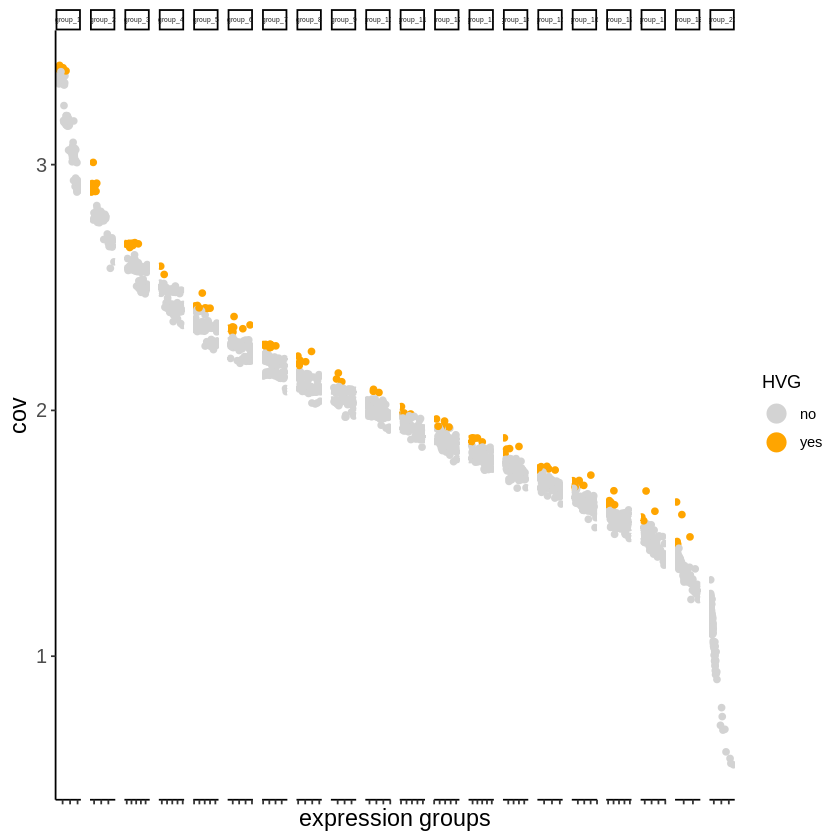

In [6]:
# dimension reduction
my_giotto_object <- calculateHVG(gobject = my_giotto_object)
my_giotto_object <- runPCA(gobject = my_giotto_object)
my_giotto_object <- runUMAP(my_giotto_object, dimensions_to_use = 1:5)

In [7]:
# @fix missing line
my_giotto_object <- createNearestNetwork(gobject = my_giotto_object)

# leiden clustering

In [8]:
# clustering
name = 'leiden_clus'
clustering=setDT(clustering)
icdt=clustering[,c('X','spatial.cluster')]
colnames(icdt)=c('cell_ID', name)

In [33]:
my_giotto_object=addCellMetadata(gobject = my_giotto_object, 
                new_metadata = icdt[, c('cell_ID', name), with = F],
                              by_column = T, column_cell_ID = 'cell_ID')

In [36]:
# annotate
metadata = pDataDT(my_giotto_object)
uniq_clusters = length(unique(metadata$leiden_clus))
clusters_cell_types = paste0('cell ', LETTERS[1:uniq_clusters])
names(clusters_cell_types) = 1:uniq_clusters

In [37]:
my_giotto_object = annotateGiotto(gobject = my_giotto_object, 
                              annotation_vector = clusters_cell_types, 
                              cluster_column = 'leiden_clus', 
                              name = 'cell_types')


In [38]:
# create network (required for binSpect methods)
my_giotto_object = createSpatialNetwork(gobject = my_giotto_object, minimum_k = 2)

# identify genes with a spatial coherent expression profile
km_spatialgenes = binSpect(my_giotto_object, bin_method = 'kmeans')


 This is the single parameter version of binSpect
 1. matrix binarization complete 

 2. spatial enrichment test completed 

 3. (optional) average expression of high expressing cells calculated 

 4. (optional) number of high expressing cells calculated 


In [47]:
# set LR database to simulated 
LR_data = data.table::fread(system.file("simulation", "human_ligand_receptors.txt", package = 'Giotto'))
lr = read.csv('~/1_spatial/1_Tumor/db.csv',row.names = 1)

# LR_data = LR_data[1:946,]
LR_data$humanLigand = lr$ligand
LR_data$humanReceptor = lr$receptor

In [143]:
# real data
LR_data = data.table::fread(system.file("extdata", "human_ligand_receptors.txt", package = 'Giotto'))

In [141]:
# # shuffled list 

# neg=read.csv('~/1_spatial/1_Tumor/neg_list.csv')
# neg=setDT(neg)
# neg=neg[,c('ligand','receptor')]
# colnames(neg)=colnames(LR_data)
# LR_data=neg

In [ ]:
# neg ctr in Fig 2A
# LR_data=LR_data[1:4,]
# LR_data=data.frame(LR_data)
# LR_data[1,c('humanLigand','humanReceptor')] = c('FGF2','FZD8')
# LR_data[2,c('humanLigand','humanReceptor')] = c('PHF5A','EDEM3')

In [87]:
LR_data[, ligand_det := ifelse(humanLigand %in% my_giotto_object@gene_ID, T, F)]
LR_data[, receptor_det := ifelse(humanReceptor %in% my_giotto_object@gene_ID, T, F)]
LR_data=setDT(LR_data)

In [88]:
LR_data_det = LR_data[ligand_det == T & receptor_det == T]
select_ligands = LR_data_det$humanLigand
select_receptors = LR_data_det$humanReceptor

In [89]:
## get statistical significance of gene pair expression changes based on expression ##
expr_only_scores = exprCellCellcom(gobject = my_giotto_object,
                                   cluster_column = 'cell_types',
                                   random_iter = 500,
                                   gene_set_1 = select_ligands,
                                   gene_set_2 = select_receptors)

simulation  1 
simulation  2 
simulation  3 
simulation  4 
simulation  5 
simulation  6 
simulation  7 
simulation  8 
simulation  9 
simulation  10 
simulation  11 
simulation  12 
simulation  13 
simulation  14 
simulation  15 
simulation  16 
simulation  17 
simulation  18 
simulation  19 
simulation  20 
simulation  21 
simulation  22 
simulation  23 
simulation  24 
simulation  25 
simulation  26 
simulation  27 
simulation  28 
simulation  29 
simulation  30 
simulation  31 
simulation  32 
simulation  33 
simulation  34 
simulation  35 
simulation  36 
simulation  37 
simulation  38 
simulation  39 
simulation  40 
simulation  41 
simulation  42 
simulation  43 
simulation  44 
simulation  45 
simulation  46 
simulation  47 
simulation  48 
simulation  49 
simulation  50 
simulation  51 
simulation  52 
simulation  53 
simulation  54 
simulation  55 
simulation  56 
simulation  57 
simulation  58 
simulation  59 
simulation  60 
simulation  61 
simulation  62 
simulation  63 
s

In [90]:
head(expr_only_scores)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
FGF2-FZD8,cell C,0.3929477,FGF2,cell D,0.085188044,FZD8,0.4781357,31,98,0.2767212,0.2014145,0.6179109,0.000,cell C--cell D,0.000,1.1096938
FGF2-FZD8,cell A,0.3512368,FGF2,cell D,0.085188044,FZD8,0.4364248,47,98,0.2802450,0.1561798,0.4964466,0.032,cell A--cell D,0.080,0.5445573
FGF2-FZD8,cell C,0.3929477,FGF2,cell B,0.035939619,FZD8,0.4288873,31,117,0.2759279,0.1529594,0.4925043,0.004,cell C--cell B,0.016,0.8844787
FGF2-FZD8,cell C,0.3929477,FGF2,cell A,0.007204208,FZD8,0.4001519,31,47,0.2753624,0.1247895,0.4140821,0.012,cell C--cell A,0.048,0.5460744
FGF2-FZD8,cell C,0.3929477,FGF2,cell C,0.004053335,FZD8,0.3970010,31,31,0.2764481,0.1205529,0.4007977,0.000,cell C--cell C,0.000,0.7197846
FGF2-FZD8,cell A,0.3512368,FGF2,cell B,0.035939619,FZD8,0.3871764,47,117,0.2794517,0.1077247,0.3605280,0.092,cell A--cell B,0.368,0.1565240


In [91]:
## get statistical significance of gene pair expression changes upon cell-cell interaction
spatial_all_scores = spatCellCellcom(my_giotto_object,
                                     spatial_network_name = 'Delaunay_network',
                                     cluster_column = 'cell_types',
                                     random_iter = 500,
                                     gene_set_1 = select_ligands,
                                     gene_set_2 = select_receptors,
                                     adjust_method = 'fdr',
                                     do_parallel = T,
                                     cores = 4,
                                     verbose = 'none')

In [92]:
spatial_all_scores

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
FGF2-FZD8,cell C,0.44300295,FGF2,cell A,0.011286592,FZD8,0.4542895,36,30,0.40419376,0.050095788,1.366615e-01,0.464,cell C--cell A,0.4640000,4.557417e-02
FGF2-FZD8,cell B,0.41616967,FGF2,cell A,0.016929889,FZD8,0.4330996,22,20,0.15747208,0.275627474,1.049989e+00,0.008,cell B--cell A,0.0320000,1.569576e+00
FGF2-FZD8,cell C,0.39294768,FGF2,cell C,0.004053335,FZD8,0.3970010,98,98,0.39700101,0.000000000,3.203427e-15,1.000,cell C--cell C,1.0000000,0.000000e+00
FGF2-FZD8,cell A,0.37587490,FGF2,cell C,0.000000000,FZD8,0.3758749,30,36,0.35358705,0.022287854,6.920292e-02,0.768,cell A--cell C,0.9160000,2.636945e-03
FGF2-FZD8,cell A,0.34057965,FGF2,cell A,0.007360821,FZD8,0.3479405,46,46,0.35814077,-0.010200301,-3.248394e-02,0.374,cell A--cell A,0.3740000,-1.387481e-02
FGF2-FZD8,cell C,0.32077969,FGF2,cell B,0.000000000,FZD8,0.3207797,7,5,0.42156437,-0.100784680,-3.097802e-01,0.676,cell C--cell B,0.6760000,-5.267915e-02
FGF2-FZD8,cell A,0.20524791,FGF2,cell B,0.043352737,FZD8,0.2486006,20,22,0.38675428,-0.138153631,-4.816184e-01,0.200,cell A--cell B,0.5600000,-1.212773e-01
FGF2-FZD8,cell B,0.06827800,FGF2,cell D,0.165051835,FZD8,0.2333298,21,16,0.23754717,-0.004217327,-1.813864e-02,0.978,cell B--cell D,0.9780000,-1.752400e-04
FGF2-FZD8,cell B,0.15236708,FGF2,cell B,0.036249443,FZD8,0.1886165,116,116,0.18693193,0.001684597,8.445392e-03,0.878,cell B--cell B,0.8780000,4.772110e-04


In [67]:
head(spatial_all_scores)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
ADIPOQ-ADIPOR1,cell D,0,ADIPOQ,cell A,1.1413856,ADIPOR1,1.1413856,2,3,0.6900686,0.451317017,0.651901501,0.328,cell D--cell A,0.9833961,4.740313e-03
ADIPOQ-ADIPOR1,cell B,0,ADIPOQ,cell C,0.7611753,ADIPOR1,0.7611753,5,7,0.7258899,0.035285416,0.060357503,0.760,cell B--cell C,0.9982488,4.594383e-05
ADIPOQ-ADIPOR1,cell B,0,ADIPOQ,cell A,0.6920022,ADIPOR1,0.6920022,22,20,0.7530795,-0.061077311,-0.107175774,0.680,cell B--cell A,1.0000000,0.000000e+00
ADIPOQ-ADIPOR1,cell A,0,ADIPOQ,cell D,0.6860755,ADIPOR1,0.6860755,3,2,0.6308790,0.055196542,0.105035382,0.848,cell A--cell D,1.0000000,0.000000e+00
ADIPOQ-ADIPOR1,cell A,0,ADIPOQ,cell A,0.6809383,ADIPOR1,0.6809383,46,46,0.6837936,-0.002855294,-0.005265213,0.754,cell A--cell A,1.0000000,0.000000e+00
ADIPOQ-ADIPOR1,cell A,0,ADIPOQ,cell C,0.6744622,ADIPOR1,0.6744622,30,36,0.6469482,0.027513995,0.052186621,0.708,cell A--cell C,1.0000000,0.000000e+00


In [ ]:
# write.csv(spatial_all_scores, file='/home/yoyo/1_spatial/7_SVCA/melanoma/neg2pos/rescale25/giores.csv')

# write.csv(spatial_all_scores, file='/home/yoyo/1_spatial/1_Tumor/giores_real.csv')